RL Fall 99

Homework #4 - MDP

Ali Elahi SID: 810696336

TD - Tree Backup

# Importing essential libraries

In [1]:
import random
import pprint
import io
import numpy as np
import sys
import numpy as np
from gym.envs.toy_text import discrete
from colorama import Fore, Back, Style
import matplotlib.pyplot as plt
import bisect
from tqdm import tqdm

In [2]:
from amalearn.environment import MutliArmedBanditEnvironment
from amalearn.environment import EnvironmentBase
from amalearn.reward import GaussianReward
from amalearn.agent import RandomBanditAgent
from amalearn.agent import AgentBase

# Utils

In [3]:
def sliding_window(x):
    returns = []
    for i in range(len(x)-20):
        returns.append(np.array(x[i:i+20]).mean())
    return returns

# Class definitions

In [4]:
actions = {
    0: 'U',
    1: 'R',
    2: 'D',
    3: 'L'
}

In [5]:
%run Environment.ipynb

In [6]:
class Tree_backup_Agent(AgentBase):
    def __init__(self, id, environment, action_definition, gamma, n_step = 1):
        super(Tree_backup_Agent, self).__init__(id, environment)
        
        self.Q = np.zeros((100, 4))
        self.episode_num = 0
        self.policy = np.ones((100, 4)) / len(action_definition)
        self.alpha = 0.5
        self.gamma = gamma
        self.epsilon = 1
        self.n_step = n_step
    
    def show(self):
        print(self.Q1[:10])
        print(self.Q2[:10])
        # print(self.Returns)
        print(self.policy)
        # print(self.episode_num)
    
    def show_policy(self):
        for i in range(10):
            for j in range(10):
                if (i, j) in [(1,3), (4, 1), (6,2)] :
                    print("•", end = " ")
                elif (i, j) in [(3,3), (3,4), (3,5), (4,3), (5,3), (5,4)] :
                    print("█", end = " ")
                else:
                    print(actions[np.argmax(self.policy[10 * i + j])], end = " ")
            print()
        
    def update_epsilon(self, x):
        x /= 20
        return 2 ** (1 - int(x)/30) / 2
    
    def get_action(self, state):
        return np.random.choice(4, 1, p = self.policy[state])[0]
    
    def update_policy(self):
        self.epsilon = self.update_epsilon(self.episode_num)
        for s in range(100):
            self.policy[s] = self.epsilon / 4
            self.policy[s][np.argmax(self.Q[s])] += (1 - self.epsilon)
    
    def update_state_ploicy(self, s, a):
        self.epsilon = self.update_epsilon(self.episode_num)
        self.policy[s] = self.epsilon / 4
        self.policy[s][a] += (1 - self.epsilon)
    
    def take_action(self, s = 45) -> (object, float, bool, object):
        self.episode_num += 1
        terminate = False
        self.environment.reset()
        G = 0
        while True:
            R = 0
            act = self.get_action(s)
            ns0, r0, done, info = self.environment.step(act)
            G = self.gamma * G + r0
            R += r0
            
            if terminate:
                break
            if done:
                terminate = True
            
            for i in range(self.n_step):
                act1 = self.get_action(ns0)
                ns1, r1, done, info = self.environment.step(act1)
                G = self.gamma * G + r1
                R += self.gamma * r1
                acts = [0,1,2,3]
                # acts.remove(act1)
                act1 = self.get_action(s)
                expected = (self.gamma ** (i+1)) * np.array([self.policy[ns0][i] * self.Q[ns0][i] for i in acts]).sum()
            
            self.Q[s][act] += \
            self.alpha * (R + expected - self.Q[s][act])
            
            s = ns1
            if terminate:
                break
            if done:
                terminate = True
            
        self.update_policy()
        return G

# Runing Algorithms

In [7]:
environment = GridworldEnv()
agent = Tree_backup_Agent('1', environment, actions, 1, 1)

In [8]:
Gs = []
for i in tqdm(range(1500)):
    Gs.append(agent.take_action())

100%|██████████| 1500/1500 [00:46<00:00, 31.92it/s] 


In [9]:
environment = GridworldEnv()
agent = Tree_backup_Agent('1', environment, actions, 1, 2)

In [10]:
Gs2 = []
for i in tqdm(range(1500)):
    Gs2.append(agent.take_action())

100%|██████████| 1500/1500 [01:06<00:00, 22.55it/s] 


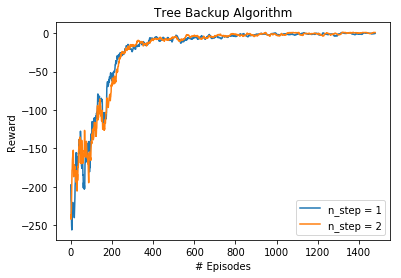

In [13]:
plt.plot(sliding_window(Gs), label = 'n_step = 1')
plt.plot(sliding_window(Gs2), label = 'n_step = 2')
plt.title('Tree Backup Algorithm')
plt.xlabel('# Episodes')
plt.ylabel('Reward')
plt.legend()
plt.show()

In [12]:
print('Policy:')
print()
agent.show_policy()

Policy:

U L L L L L L L L L 
U U L • U U U L L U 
U U L L R U U U U U 
U U U █ █ █ U U U U 
U • U █ R R R U L U 
D L L █ █ R U U U L 
D D • D D R R R U U 
D D D D D D R R U U 
D D D D R R R U R U 
L R R R R R R R R U 
